# Notebook to build Normative model

In [1]:
from nfact_id.functions.idp_functions import create_wide_df
import bambi as bmb
import arviz as az
from decouple import config
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import os
os.environ["CPATH"] = "/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/v1"

## Get component directory

In [2]:
component_dir = os.path.join(config("base_dir"), "component_loadings", "hcp")
storage_dir = os.path.join(config("base_dir"), "group_tests")

## Pre-process data

In [3]:
df_wide = create_wide_df(os.path.join(component_dir, "G_component_loadings.csv"), os.path.join(component_dir, "W_component_loadings.csv"))
participant_info = pd.read_csv(os.path.join(component_dir, "participants_dr.csv"))
df_wide['group'] = participant_info['phenotype']

### Create long df

In [4]:
long_df = pd.melt(df_wide, id_vars=['subject', 'group'], var_name='component', value_name='value')
long_df['component_num'] = long_df['component'].str.extract(r'(\d+)').astype(int)
long_df = long_df.sort_values(by=['subject', 'component_num'])
long_df['comp_type'] = long_df['component'].apply(lambda x: 'Grey' if 'G_' in x else 'White')
long_df = long_df.drop(columns='component').reset_index(drop=True)

In [5]:
long_df

,subject,group,value,component_num,comp_type
0,1006,psychosis,0.548849,0,Grey
1,1006,psychosis,0.603816,0,White
2,1006,psychosis,0.786293,1,Grey
3,1006,psychosis,0.732054,1,White
4,1006,psychosis,0.719728,2,Grey
...,...,...,...,...,...
111595,s0209,Depression,0.722722,97,White
111596,s0209,Depression,0.662947,98,Grey
111597,s0209,Depression,0.716090,98,White
111598,s0209,Depression,0.585808,99,Grey


## Get controls

In [6]:
controls = long_df[long_df['group'].str.contains("Control")].reset_index(drop=True)
controls_grey = controls[controls['comp_type'].str.contains("Grey")]
controls_white = controls[controls['comp_type'].str.contains("White")]

## The models

In [7]:
model_ctrl_white = bmb.Model(
   "value ~ 0 + component_num + (1 | subject)",
    data=controls_white,
    family="beta",
    categorical=['subject', 'component_num'],
    priors={
        "component_num": bmb.Prior("Normal", mu=0, sigma=1), # More informative sigma
        "1|subject": bmb.Prior("Normal", mu=0.0, sigma=bmb.Prior("HalfNormal", sigma=0.5)),
    }

)

In [8]:
model_ctrl_grey = bmb.Model(
    "value ~ 0 + component_num + (1 | subject)",
    data=controls_grey,
    family="beta",
    categorical=['subject', 'component_num'],
    priors={
        "component_num": bmb.Prior("Normal", mu=0, sigma=1), # More informative sigma
        "1|subject": bmb.Prior("Normal", mu=0.0, sigma=bmb.Prior("HalfNormal", sigma=0.5)),
    }
)

### View priors

In [9]:
model_ctrl_white

       Formula: value ~ 0 + component_num + (1 | subject)
        Family: beta
          Link: mu = logit
  Observations: 16200
        Priors: 
    target = mu
        Common-level effects
            component_num ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
        
        Auxiliary parameters
            kappa ~ HalfCauchy(beta: 1.0)

In [10]:
model_ctrl_grey

       Formula: value ~ 0 + component_num + (1 | subject)
        Family: beta
          Link: mu = logit
  Observations: 16200
        Priors: 
    target = mu
        Common-level effects
            component_num ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
        
        Auxiliary parameters
            kappa ~ HalfCauchy(beta: 1.0)

## Build the models

In [11]:
idata_ctrl_white = model_ctrl_white.fit(tune=3000, draw=3000, cores=4, chains=4, mp_ctx="spawn", random_seed=1234, target_accept=0.98, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value_kappa, component_num, 1|subject_sigma, 1|subject_offset]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 713 seconds.


In [12]:
idata_ctrl_grey = model_ctrl_grey.fit(tune=3000, draw=3000, cores=10, chains=4, mp_ctx="spawn", random_seed=1234, target_accept=0.98, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value_kappa, component_num, 1|subject_sigma, 1|subject_offset]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 713 seconds.


## Explore normative models

In [13]:
az.summary(idata_ctrl_white)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
component_num[0],0.769,0.026,0.719,0.818,0.001,0.000,1944.0,2148.0,1.0
component_num[1],1.120,0.029,1.068,1.176,0.001,0.001,2722.0,2623.0,1.0
component_num[2],1.147,0.030,1.092,1.203,0.001,0.000,1995.0,2644.0,1.0
component_num[3],0.321,0.025,0.274,0.368,0.001,0.000,1901.0,2563.0,1.0
component_num[4],0.997,0.027,0.948,1.049,0.001,0.000,1941.0,2501.0,1.0
...,...,...,...,...,...,...,...,...,...
1|subject[s0021],0.036,0.033,-0.025,0.097,0.001,0.001,2477.0,2348.0,1.0
1|subject[s0023],0.061,0.034,-0.002,0.123,0.001,0.001,3912.0,2979.0,1.0
1|subject[s0024],0.012,0.033,-0.053,0.073,0.001,0.001,2856.0,2450.0,1.0
1|subject[s0027],0.001,0.033,-0.061,0.060,0.001,0.001,3274.0,2536.0,1.0


In [14]:
az.summary(idata_ctrl_grey)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
component_num[0],-0.002,0.020,-0.039,0.036,0.0,0.000,3233.0,2689.0,1.00
component_num[1],1.387,0.024,1.341,1.431,0.0,0.000,3512.0,2382.0,1.00
component_num[2],1.039,0.024,0.995,1.084,0.0,0.000,3074.0,2132.0,1.00
component_num[3],-0.239,0.021,-0.278,-0.198,0.0,0.000,3055.0,2249.0,1.01
component_num[4],1.543,0.026,1.494,1.590,0.0,0.000,3858.0,2824.0,1.00
...,...,...,...,...,...,...,...,...,...
1|subject[s0021],0.019,0.027,-0.033,0.069,0.0,0.000,4522.0,2903.0,1.00
1|subject[s0023],-0.026,0.028,-0.078,0.026,0.0,0.001,6141.0,2521.0,1.00
1|subject[s0024],-0.038,0.026,-0.087,0.010,0.0,0.001,4388.0,2203.0,1.00
1|subject[s0027],-0.062,0.026,-0.108,-0.011,0.0,0.001,3652.0,2503.0,1.00


### plot traces

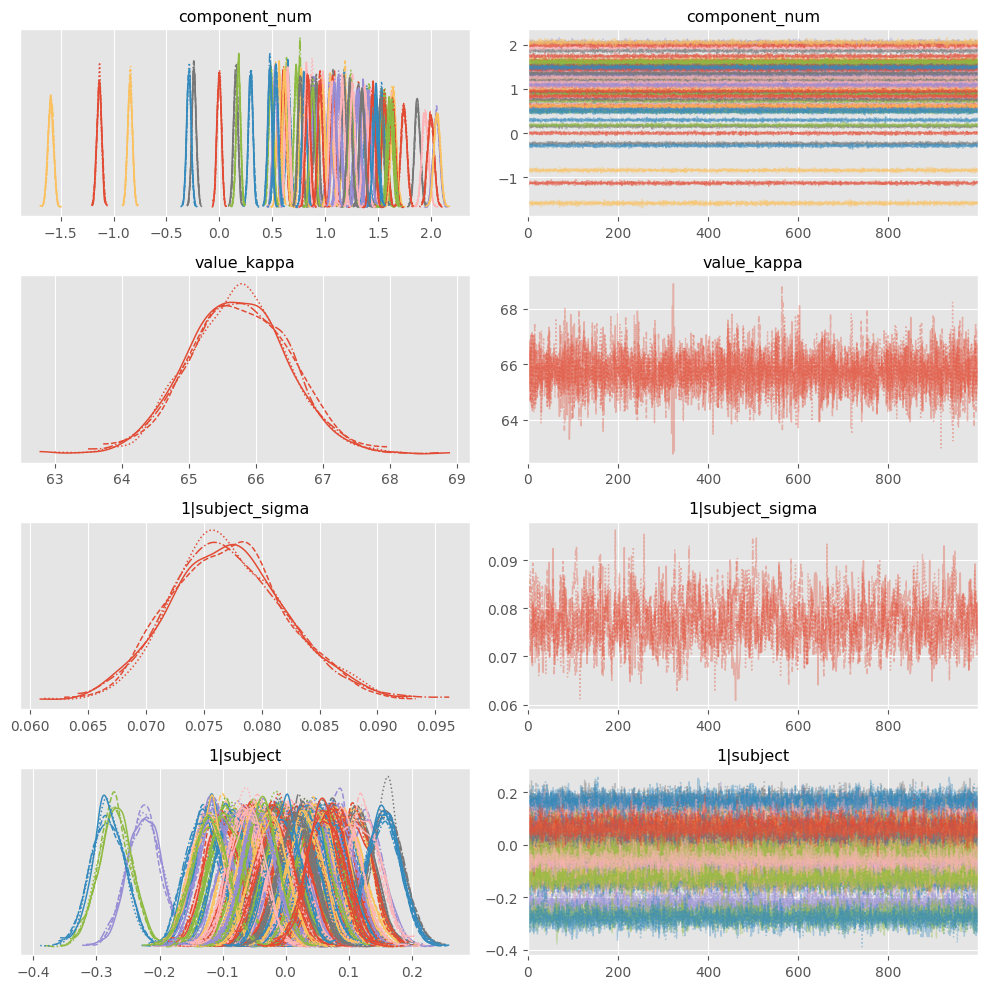

In [15]:
az.plot_trace(idata_ctrl_grey, figsize=(10,10))
plt.tight_layout()

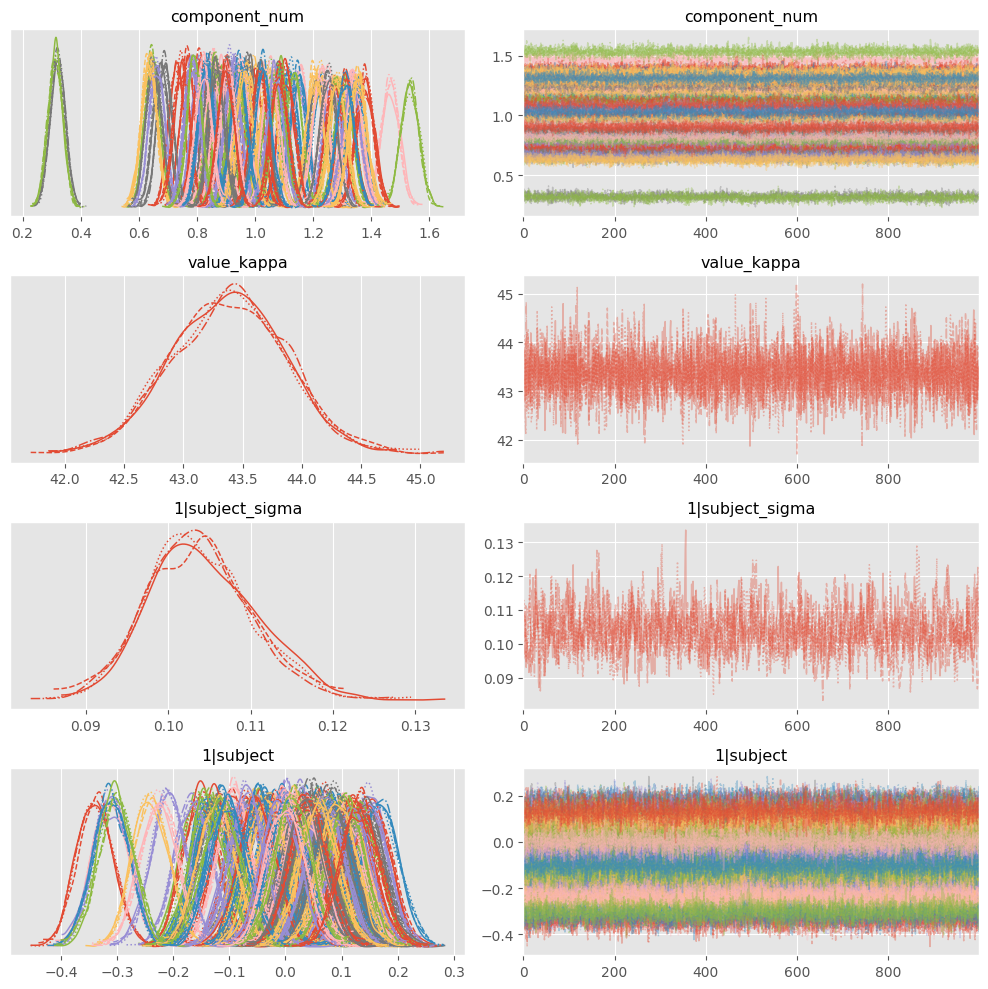

In [16]:
az.plot_trace(idata_ctrl_white, figsize=(10,10))
plt.tight_layout()

## Fit posterior predict

### Get Patient Data

In [17]:
patients = long_df[~long_df['group'].str.contains("Control")]
grey_ppc_df =  patients[patients['comp_type'].str.contains("Grey")]
white_ppc_df = patients[patients['comp_type'].str.contains("White")]

### Calculate PPC

In [18]:
model_ctrl_white.predict(idata=idata_ctrl_white, data=white_ppc_df, kind="pps", sample_new_groups=True)
model_ctrl_grey.predict(idata=idata_ctrl_grey, data=grey_ppc_df, kind="pps", sample_new_groups=True)

### Plot PPC 

<Axes: xlabel='value'>

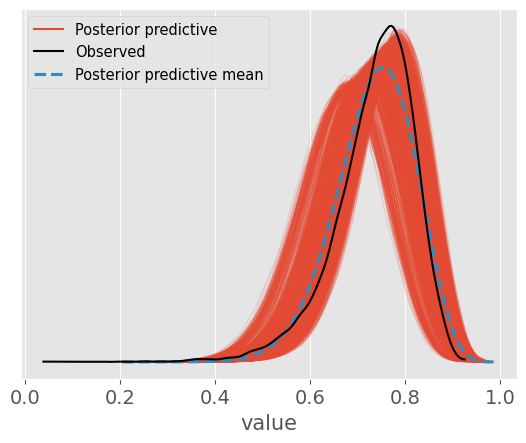

In [19]:
az.plot_ppc(idata_ctrl_white)

<Axes: xlabel='value'>

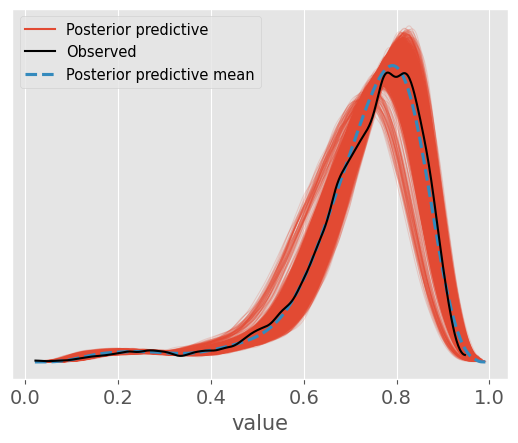

In [20]:
az.plot_ppc(idata_ctrl_grey)

## Save Models

In [ ]:
idata_ctrl_white.to_netcdf(os.path.join(storage_dir, "normative_WM_fitted.nc"))
idata_ctrl_grey.to_netcdf(os.path.join(storage_dir, "normative_GM_fitted.nc"))